# Mushrooms

### Setup

In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
from torch.optim import Optimizer
import copy
from torchinfo import summary

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = 'cuda'

In [2]:
dataset = "mushrooms.txt" 

data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2 * y - 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
def estimate_L(X, l=None):
    L = np.sum(np.linalg.norm(X, axis=1)**2) / 4 / X.shape[0]
    if l == None:
        print('Setting L such that lambda = L/1000')
        L = L * (1000 / 999)
    else:
        L = l + L
    return L

L = estimate_L(X_train, l=0)
l = 0
print('L: ', L)
print('lambda: ', l)

L:  5.25
lambda:  0


### Torch vs Manual grad calculation

In [4]:
def f(w, X, y, l):
    val = np.mean(np.log(1 + np.exp(-y * np.dot(X, w)))) + l / 2 * np.linalg.norm(w)**2
    return val

def f_torch(w, X, y, l):
    val = torch.mean(torch.log(1 + torch.exp(-y * torch.matmul(X, w)))) + l / 2 * torch.linalg.norm(w)**2
    return val

### just for a demo
def f_grad(w, X, y, l):
    c = -y / (1 + np.exp(y * np.dot(X, w)))
    grad = np.mean(c[:, None] * X, axis=0) + l*w
    return grad

In [7]:
x_0 = np.random.randn(X.shape[1])
assert f(x_0, X_train, y_train, l) == f_torch(torch.tensor(x_0), torch.tensor(X_train), torch.tensor(y_train), torch.tensor(l))

In [8]:
w = torch.tensor(x_0, requires_grad=True)

In [9]:
y = f_torch(w, torch.tensor(X_train), torch.tensor(y_train), torch.tensor(l))

In [10]:
y.backward()

In [11]:
torch.linalg.norm(w.grad - f_grad(x_0, X_train, y_train, l), ord=1)

tensor(5.2729e-15, dtype=torch.float64)

### Implementation of L-SVRG

In [5]:
class LSVRG(Optimizer):
    r"""Optimization class for calculating the gradient of one iteration.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
    """
    def __init__(self, params, lr, weight_decay=0):
        self.full_grad_pg = None
        
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
            
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(LSVRG, self).__init__(params, defaults)
    
    def get_param_groups(self):
            return self.param_groups

    def set_full_grad(self, full_grad_param_groups):
        ''' 
            Set full gradient at new point w^k
        '''
        if self.full_grad_pg is None:
            self.full_grad_pg = copy.deepcopy(full_grad_param_groups)
        
        for old_group, new_group in zip(self.full_grad_pg, full_grad_param_groups):  
            for old_p, new_p in zip(old_group['params'], new_group['params']):
                old_p.grad = new_p.grad.clone()
                
    def step(self, params):
        """Performs a single optimization step.
        """
        for group, wk_group, full_grad_group in zip(self.param_groups, params, self.full_grad_pg):

            for x_k, w_k, fgp in zip(group['params'], wk_group['params'], full_grad_group['params']):
                # if x_k.grad is None:
                #     continue
                # if w_k.grad is None:
                #     continue

                g_k = x_k.grad.data - w_k.grad.data + fgp.grad.data
                if group['weight_decay'] != 0:
                    g_k.add_(x_k.data, alpha=group['weight_decay'])
                
                x_k.data.add_(g_k, alpha=-group['lr'])


class LSVRG_Snapshot(Optimizer):
    r"""Optimization class for calculating the mean gradient (snapshot) of all samples.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
    """
    def __init__(self, params):
        defaults = dict()
        super(LSVRG_Snapshot, self).__init__(params, defaults)
      
    def get_param_groups(self):
            return self.param_groups
    
    def set_param_groups(self, new_params):
        """Copies the parameters from another optimizer. 
        """
        for group, new_group in zip(self.param_groups, new_params): 
            for p, q in zip(group['params'], new_group['params']):
                  p.data[:] = q.data[:]

In [6]:
def predict(X, model):
    with torch.no_grad():
        logits = model(X)
        logits[logits >= 0] = 1
        logits[logits < 0] = -1
    return logits.ravel()

def predict_multiclass(X, model):
    with torch.no_grad():
        logits = model(X)
    return logits.argmax(dim=1)

def accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / y_true.shape[0]

In [7]:
def train_LSVRG(model_k, model_snapshot, optimizer_k, optimizer_snapshot, train_loader, 
                loss_fn, p, num_iter, X_test, y_test, test_freq=1, predict_fn=predict):

    def calc_full_grad():
        optimizer_snapshot.zero_grad()  
        for x, y in train_loader:
            x = x.to(device)
            y_pred = model_snapshot(x)
            y = y.to(device)
            snapshot_loss = loss_fn(y_pred, y) / len(train_loader)
            snapshot_loss.backward()
        
        optimizer_k.set_full_grad(optimizer_snapshot.get_param_groups())
    
    model_k.train()
    model_snapshot.train()
    loss = []
    test_acc = []

    # calc full grad at w_k=x_0
    calc_full_grad()
    
    k = 0
    with tqdm(total=num_iter) as pbar:
        while k < num_iter:

            for x, y in train_loader:
                x = x.to(device)
                y_pred_1 = model_k(x)
                y = y.to(device)
                loss_iter = loss_fn(y_pred_1, y)

                optimizer_k.zero_grad()
                loss_iter.backward()    

                y_pred_2 = model_snapshot(x)
                loss2 = loss_fn(y_pred_2, y)

                optimizer_snapshot.zero_grad()
                loss2.backward()

                if p < 1:
                    if torch.rand(1)[0] < p: # update wk
                        # save x_k before calc x_k+1
                        x_k = copy.deepcopy(optimizer_k.get_param_groups())

                        optimizer_k.step(optimizer_snapshot.get_param_groups())

                        optimizer_snapshot.set_param_groups(x_k)
                        calc_full_grad()
                    else:
                        optimizer_k.step(optimizer_snapshot.get_param_groups())
                else: 
                    # just usual SVRG
                    if (k % p) == 0: # update wk
                        # save x_k before calc x_k+1
                        x_k = copy.deepcopy(optimizer_k.get_param_groups())

                        optimizer_k.step(optimizer_snapshot.get_param_groups())

                        optimizer_snapshot.set_param_groups(x_k)
                        calc_full_grad()
                    else:
                        optimizer_k.step(optimizer_snapshot.get_param_groups())
                        
                # logging 
                loss.append(loss_iter.data.item())
                
                if (k % test_freq) == 0:
                    if isinstance(X_test, torch.Tensor):
                        test_acc_iter = accuracy(predict_fn(X_test, model_k), y_test)
                        test_acc.append(test_acc_iter.data.item())
                    elif isinstance(X_test, torch.utils.data.DataLoader):
                        model_k.eval()
                        with torch.no_grad():
                            y_pred = torch.tensor([]).to(device)
                            y_true = torch.tensor([]).to(device)
                            for x_test, y_test in X_test:
                                pred = predict_fn(x_test.to(device), model_k)
                                y_pred = torch.concat([y_pred, pred])
                                y_true = torch.concat([y_true, y_test.to(device)])
                            test_acc_iter = accuracy(y_pred, y_true)
                            test_acc.append(test_acc_iter.data.item())
                        model_k.train()

                k += 1
                pbar.update(1)

    return loss, test_acc

In [8]:
mushrooms_model = nn.Linear(X.shape[1], 1, bias=False)
mushrooms_model.weight.data = torch.randn(1, X.shape[1])

model = mushrooms_model.to(device)
model_wk = copy.deepcopy(mushrooms_model).to(device)

In [9]:
def loss_mushrooms(y_pred, y):
    assert y_pred.shape[1] == 1 and len(y_pred.shape) == 2
    y_pred = y_pred.ravel()
    assert len(y_pred.shape) == len(y.shape) == 1
    
    return torch.mean(torch.log(1 + torch.exp(-y * y_pred)))

In [32]:
optimizer = LSVRG(model.parameters(), lr=1/6/L)
optimizer_snapshot = LSVRG_Snapshot(model_wk.parameters())

In [158]:
BATCH_SIZE = 128

train_ds = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)

X_test_tensor = torch.tensor(X_test).float().to(device)
y_test_tensor = torch.tensor(y_test).float().to(device)

In [34]:
P = 1 / len(train_loader)
num_iter = 20 * len(train_loader) # 20 epochs

train_loss, test_acc = \
    train_LSVRG(model, model_wk, optimizer, optimizer_snapshot, train_loader, loss_mushrooms, 
                P, num_iter, X_test_tensor, y_test_tensor)

  0%|          | 0/1000 [00:00<?, ?it/s]

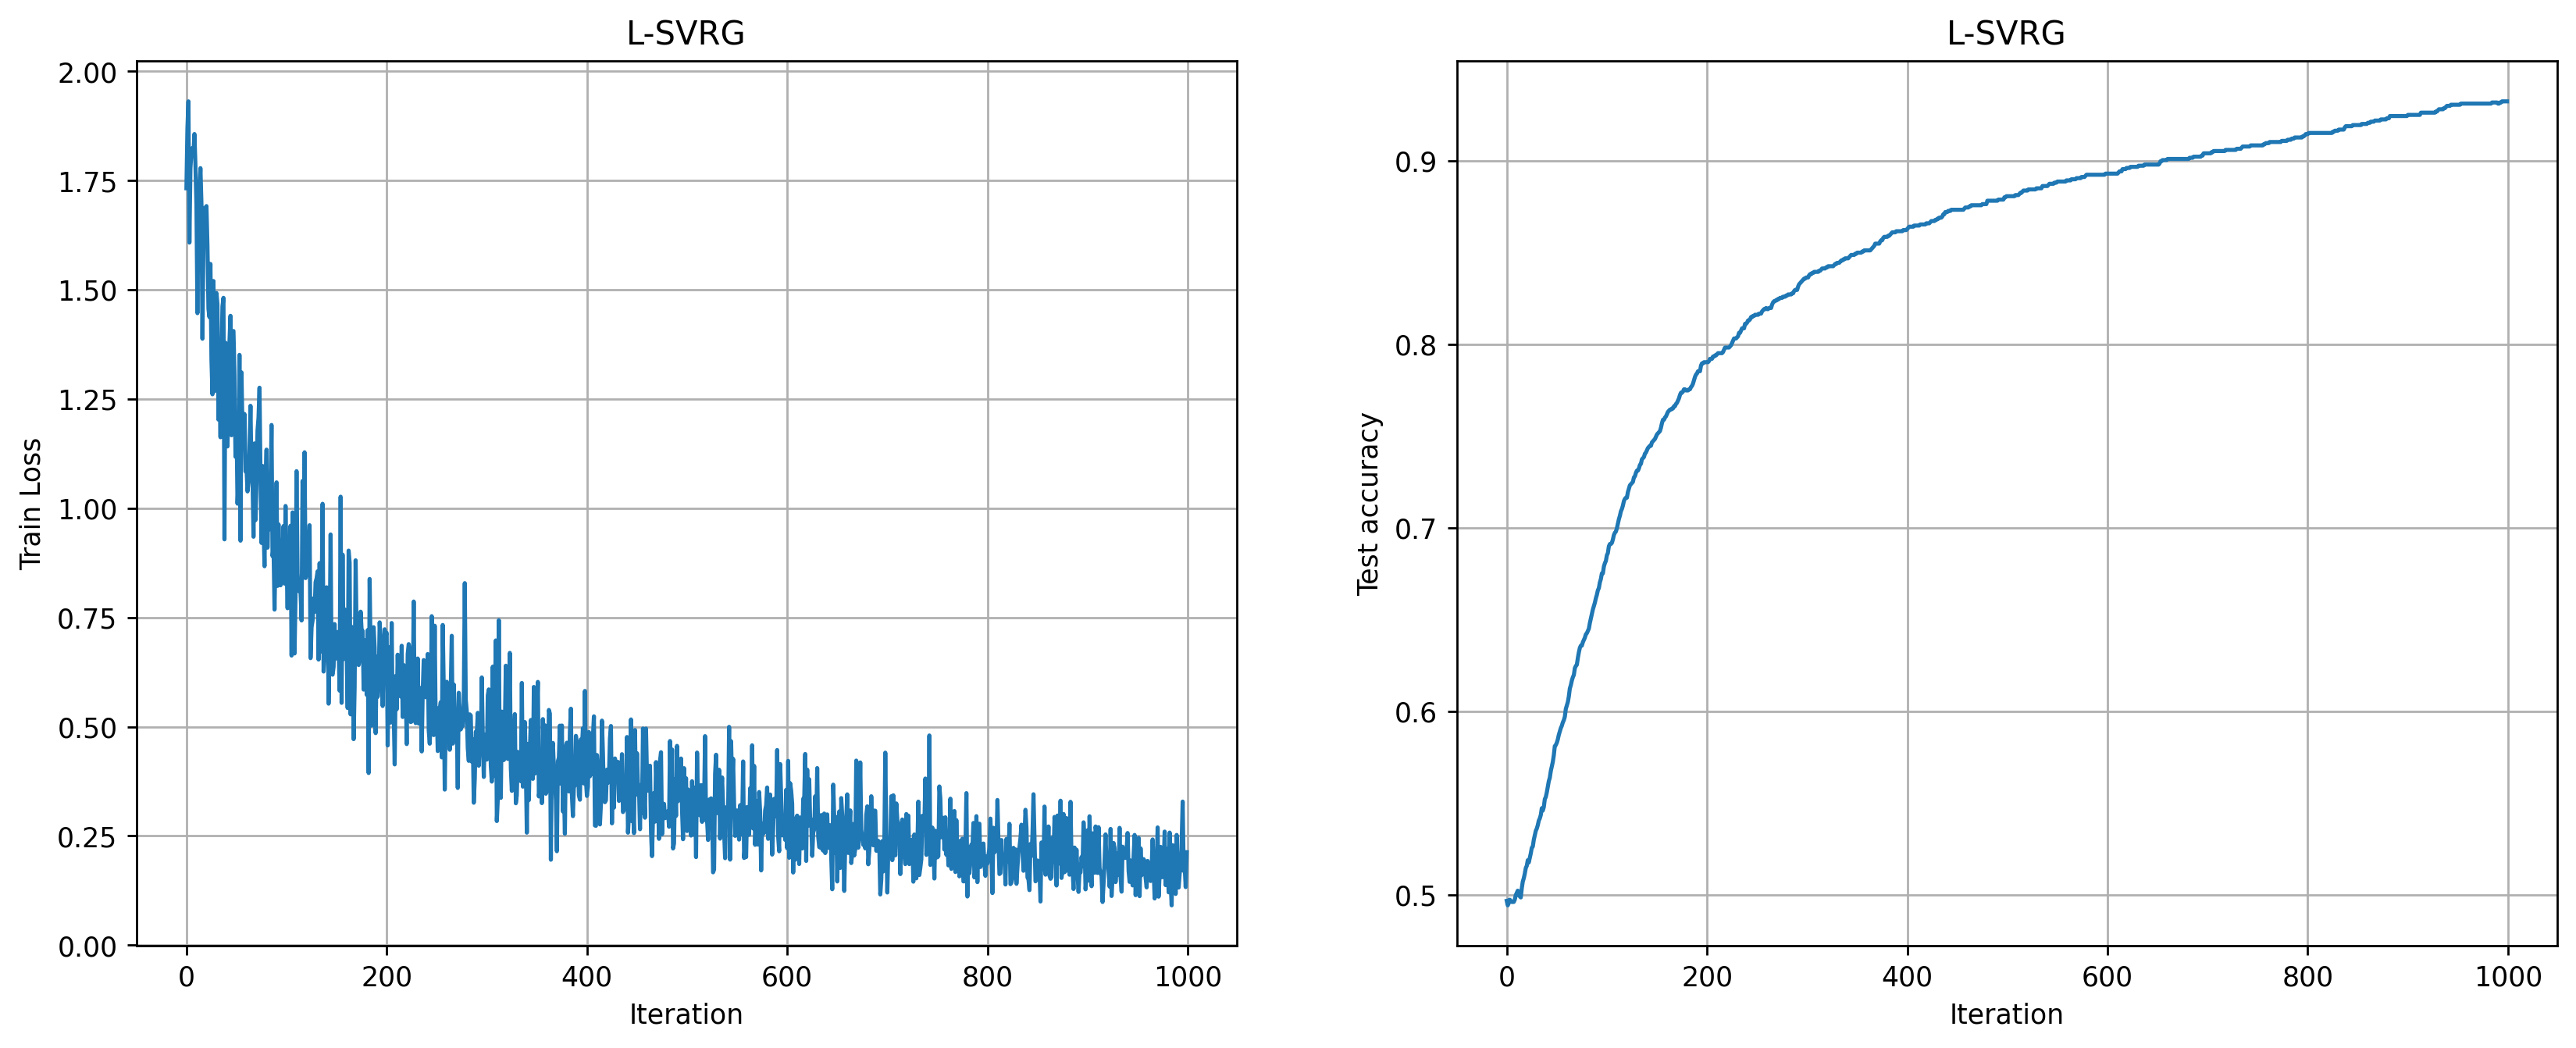

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=250)

ax[0].plot(train_loss)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel(f'Train Loss')
ax[0].set_title('L-SVRG')
ax[0].grid()

ax[1].plot(test_acc)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel(f'Test accuracy')
ax[1].set_title('L-SVRG')
ax[1].grid()

### Choosing step

It's stated in the paper that any $$\eta \leq \frac{1}{6L}$$ would guarantee a convergence. Let's search for an optimal step

In [352]:
# step_grid = np.hstack([np.linspace(0, 1/(6*L), 5)[1:], np.linspace(1/(6*L), 1, 3)[1:]])
step_grid = np.linspace(0, 1/(6*L), 5)[1:]

loss_per_step = []
accuracy_per_step = []

# del model, model_wk, optimizer, optimizer_snapshot
num_iter = 20*len(train_loader)

for step in tqdm(step_grid):
    mushrooms_model = nn.Linear(X.shape[1], 1, bias=False)
    mushrooms_model.weight.data = torch.randn(1, X.shape[1])

    model = mushrooms_model.to(device)
    model_wk = copy.deepcopy(mushrooms_model).to(device)
    
    optimizer = LSVRG(model.parameters(), lr=step)
    optimizer_snapshot = LSVRG_Snapshot(model_wk.parameters())
    
    train_loss, test_acc = \
    train_LSVRG(model, model_wk, optimizer, optimizer_snapshot, train_loader, loss_mushrooms, 
                P, num_iter, X_test_tensor, y_test_tensor)
    
    loss_per_step.append(train_loss)
    accuracy_per_step.append(test_acc)
    
    model.to('cpu')
    model_wk.to('cpu')    

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

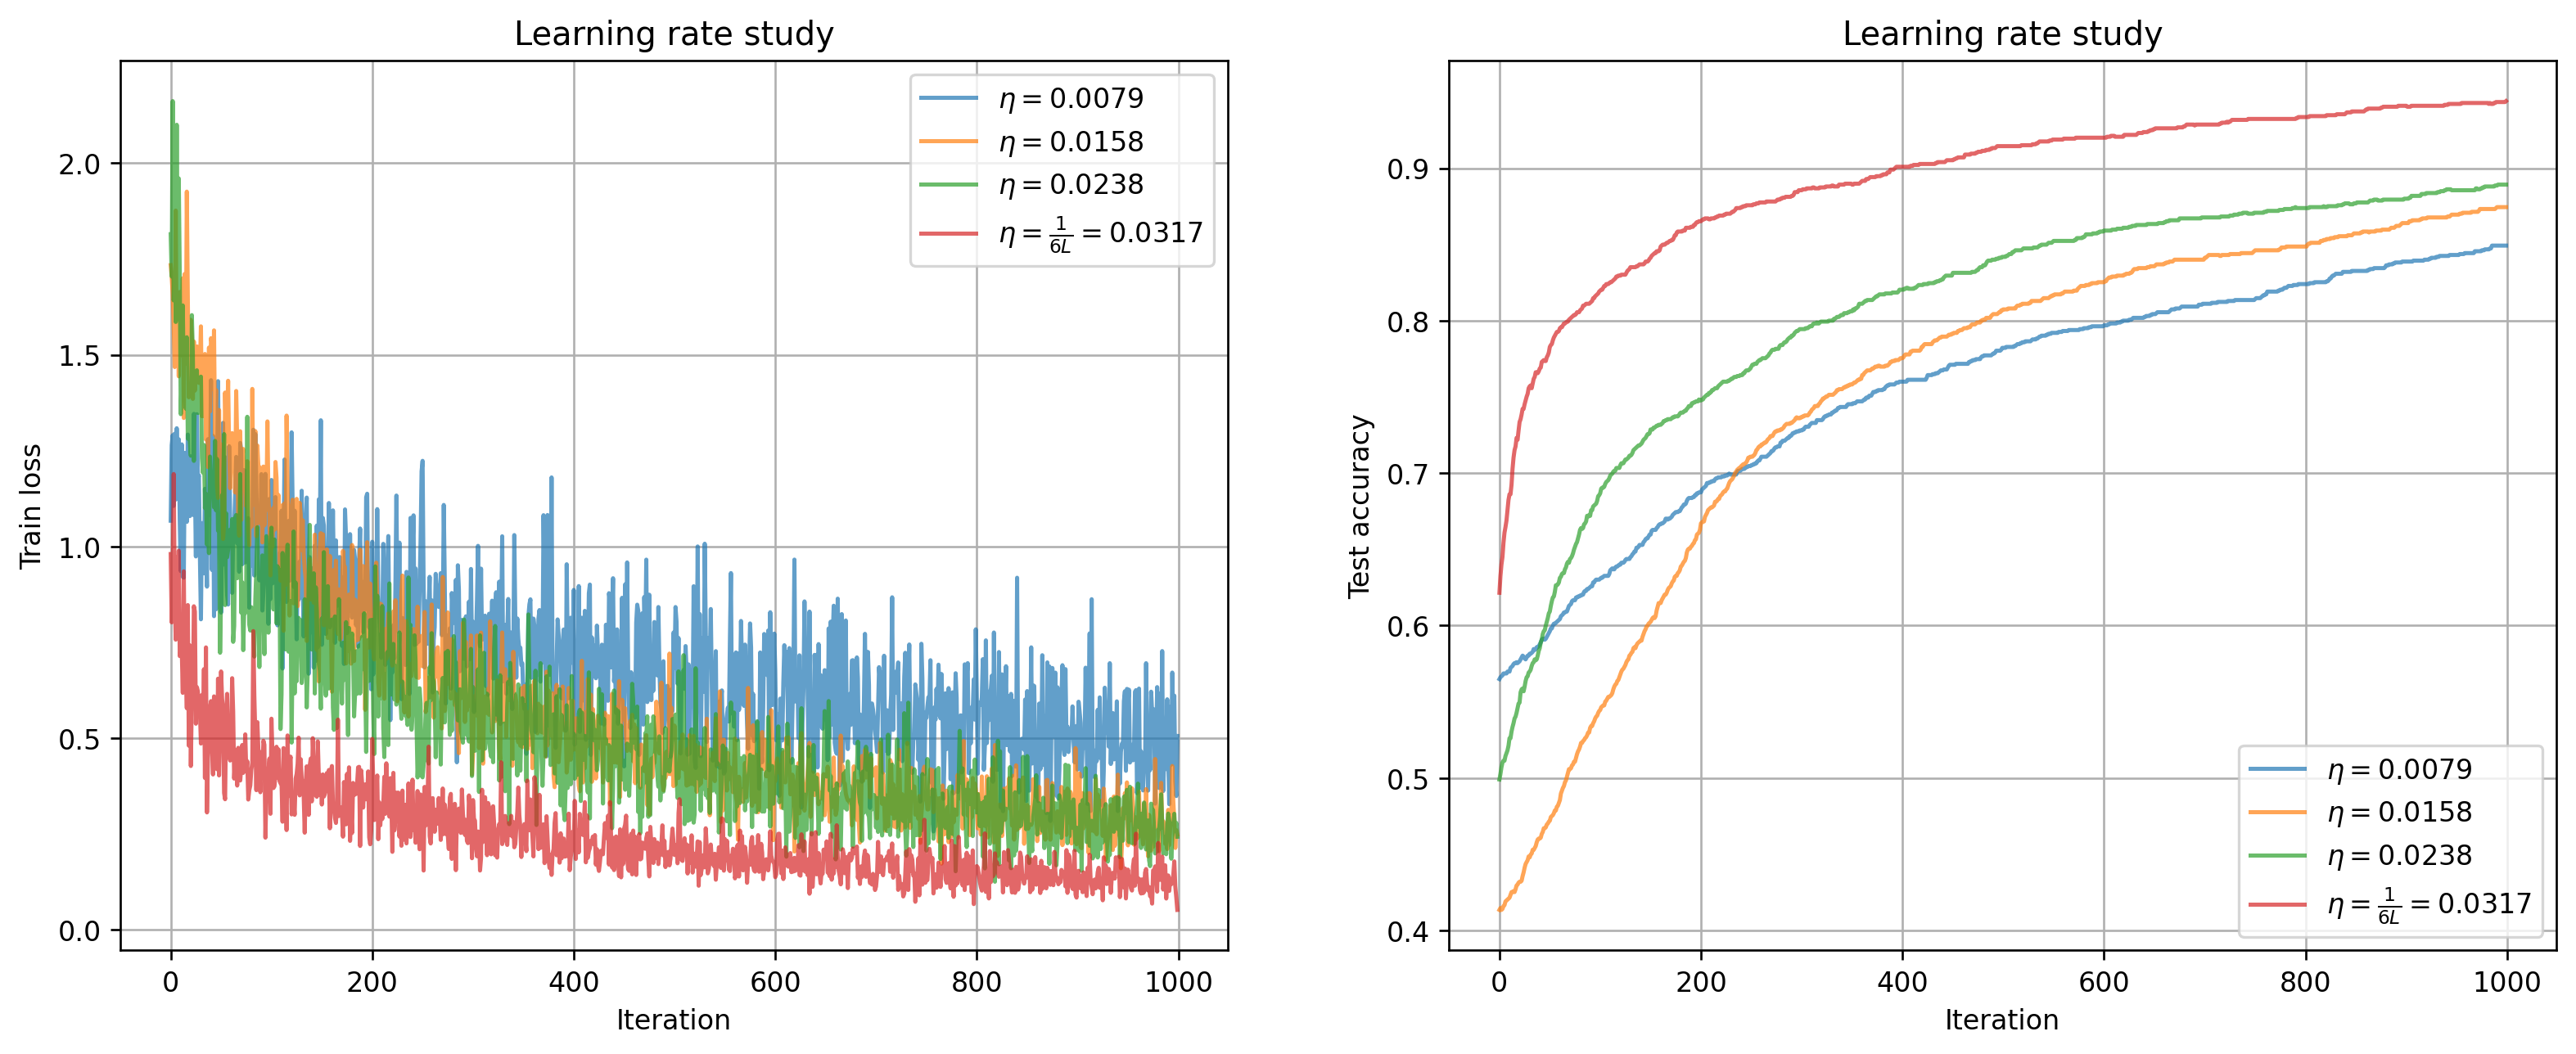

In [353]:
labels = ['$\eta=$' + f'{step:.4f}' for step in step_grid] 
labels[3] = '$\eta=\\frac{1}{6L}=$' + f'{step_grid[3]:.4f}'

fig, axs = plt.subplots(1, 2, figsize=(16,6), dpi=240)

ax = axs[0]
for i, losses in enumerate(loss_per_step):
    ax.plot(losses, label=labels[i], alpha=0.7)
# plt.yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(f'Train loss')
# plt.ylim(0.8, 1)
ax.set_title('Learning rate study')
ax.legend()
ax.grid()


ax = axs[1]
for i, test_acc in enumerate(accuracy_per_step):
    ax.plot(test_acc, label=labels[i], alpha=0.7)
# plt.yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(f'Test accuracy')
# plt.ylim(0.8, 1)
ax.set_title('Learning rate study')
ax.legend()
ax.grid()

We see that method indeed converges for any $\eta \leq \frac{1}{6L}$

### Choosing probability 

According to paper, method converges for different $$p \in \left[\min\{ \frac{1}{N}, \frac{\mu}{L} \}, \max\{ \frac{1}{N}, \frac{\mu}{L} \} \right]$$

In [164]:
n = len(train_loader)
MU = 10e-3
L = estimate_L(X_train, MU)

p_lower = min(1/n, MU/L)
p_upper = max(1/n, MU/L)
print(f'p in [{p_lower}, {p_upper}]')

p_grid = np.linspace(p_lower, p_upper, num=5)
p_grid = np.hstack([p_grid, n])
# p_grid = np.linspace(0, 1/len(train_loader), num=4)

loss_per_step = []
accuracy_per_step = []

del model, model_wk, optimizer, optimizer_snapshot
num_iter = 20*len(train_loader)

for p in tqdm(p_grid):
    mushrooms_model = nn.Linear(X.shape[1], 1, bias=False)
    mushrooms_model.weight.data = torch.randn(1, X.shape[1])

    model = mushrooms_model.to(device)
    model_wk = copy.deepcopy(mushrooms_model).to(device)
    
    optimizer = LSVRG(model.parameters(), lr=1/6/L, weight_decay=MU)
    optimizer_snapshot = LSVRG_Snapshot(model_wk.parameters())
    
    train_loss, test_acc = \
    train_LSVRG(model, model_wk, optimizer, optimizer_snapshot, train_loader, loss_mushrooms, 
                p, num_iter, X_test_tensor, y_test_tensor)
    
    loss_per_step.append(train_loss)
    accuracy_per_step.append(test_acc)
    
    model.to('cpu')
    model_wk.to('cpu')      

p in [0.0019011406844106466, 0.02]


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

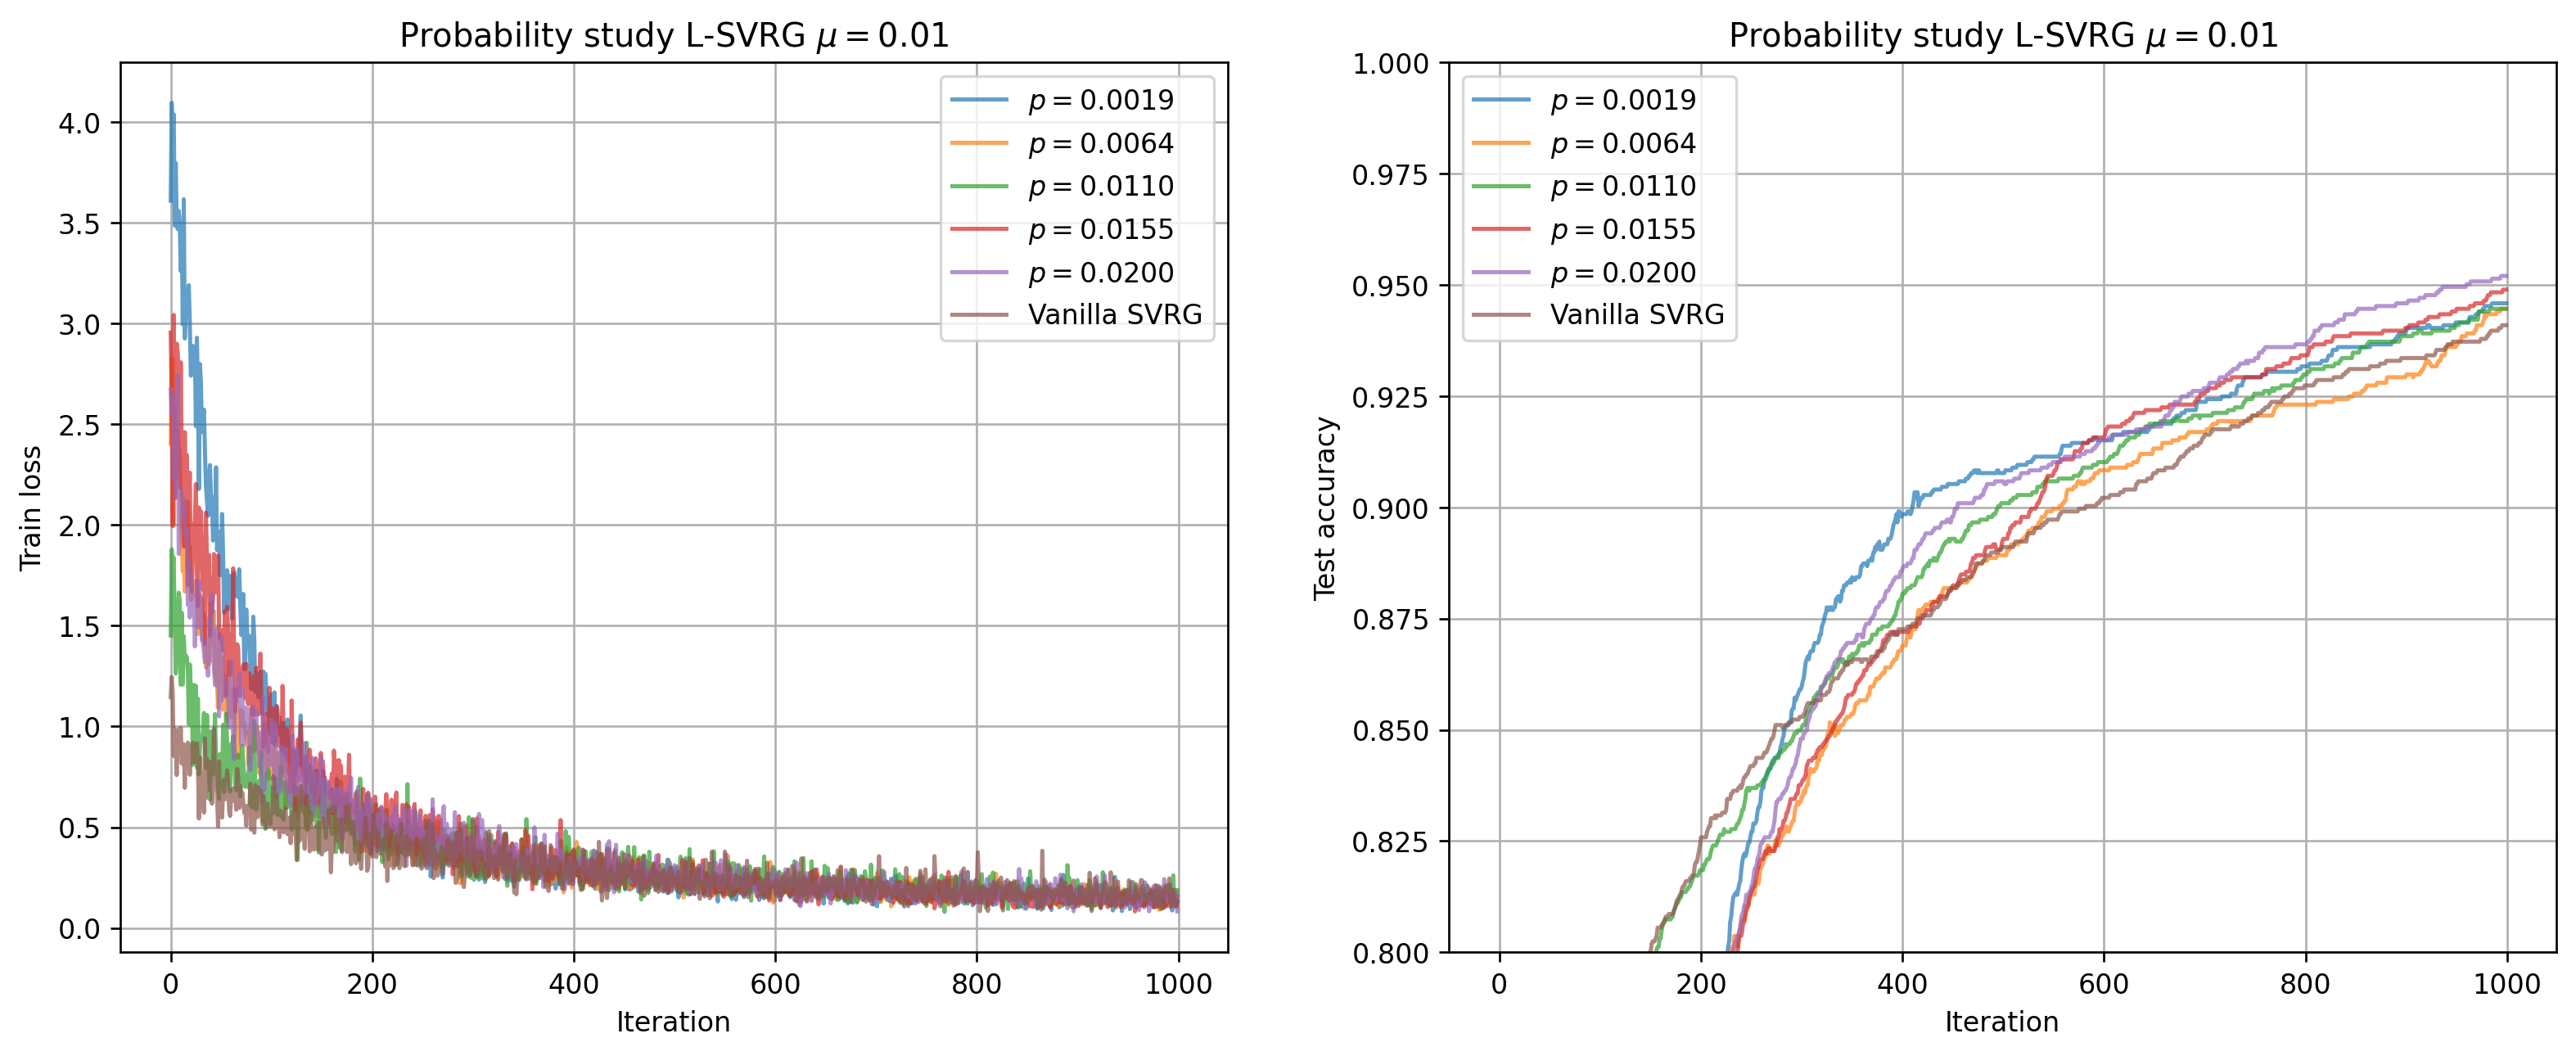

In [163]:
labels = ['$p=$' + f'{p:.4f}' for p in p_grid] 
labels[-1] = 'Vanilla SVRG'
# labels[3] = '$p=\\frac{1}{N}=$' + f'{step_grid[3]:.4f}'

fig, axs = plt.subplots(1, 2, figsize=(16,6), dpi=240)

ax = axs[0]
for i, losses in enumerate(loss_per_step):
    ax.plot(losses, label=labels[i], alpha=0.7)
# plt.yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(f'Train loss')
# plt.ylim(0.8, 1)
ax.set_title(f'Probability study L-SVRG $\mu={MU}$')
ax.legend()
ax.grid()


ax = axs[1]
for i, test_acc in enumerate(accuracy_per_step):
    ax.plot(test_acc, label=labels[i], alpha=0.7)
# plt.yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(f'Test accuracy')
plt.ylim(0.8, 1)
ax.set_title(f'Probability study L-SVRG $\mu={MU}$')
ax.legend()
ax.grid()

We see that from all the $p$ from theoretical interval method converges. Moreover, LSVRG beats the SVRG

# MNIST

In [178]:
mnist_model = nn.Sequential(
    nn.Conv2d(1, 16, 3),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

model = mnist_model.to(device)
model_wk = copy.deepcopy(mnist_model).to(device)

optimizer = LSVRG(model.parameters(), lr=5e-2, weight_decay=10e-4)
optimizer_snapshot = LSVRG_Snapshot(model_wk.parameters())

mnist_loss = torch.nn.CrossEntropyLoss()

In [167]:
from torchinfo import summary
summary(mnist_model, (128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 26, 26]         160
├─BatchNorm2d: 1-2                       [128, 16, 26, 26]         32
├─ReLU: 1-3                              [128, 16, 26, 26]         --
├─Conv2d: 1-4                            [128, 32, 24, 24]         4,640
├─BatchNorm2d: 1-5                       [128, 32, 24, 24]         64
├─ReLU: 1-6                              [128, 32, 24, 24]         --
├─Conv2d: 1-7                            [128, 64, 22, 22]         18,496
├─BatchNorm2d: 1-8                       [128, 64, 22, 22]         128
├─ReLU: 1-9                              [128, 64, 22, 22]         --
├─Conv2d: 1-10                           [128, 128, 20, 20]        73,856
├─BatchNorm2d: 1-11                      [128, 128, 20, 20]        256
├─ReLU: 1-12                             [128, 128, 20, 20]        --
├

In [168]:
BATCH_SIZE = 128
img_dir = '/ssd_new/r.fazylov/'

TRANSFORMS = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = torchvision.datasets.MNIST(img_dir, download=True, train=True, transform=TRANSFORMS)
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True, pin_memory=True)

test_ds =torchvision.datasets.MNIST(img_dir, download=True, train=False, transform=TRANSFORMS)
test_loader = torch.utils.data.DataLoader(test_ds, 4096, shuffle=False, num_workers=4, drop_last=False, pin_memory=True)

LSVRG

In [177]:
P = 1 / len(train_loader)
num_iter = 10 * len(train_loader)

train_loss, test_acc = \
    train_LSVRG(model, model_wk, optimizer, optimizer_snapshot, train_loader, mnist_loss, 
                P, num_iter, test_loader, None, test_freq=len(train_loader) // 5, predict_fn=predict_multiclass)

  0%|          | 0/4680 [00:00<?, ?it/s]

SVRG

In [179]:
num_iter = 10 * len(train_loader)

train_loss_svrg, test_acc_svrg = \
    train_LSVRG(model, model_wk, optimizer, optimizer_snapshot, train_loader, mnist_loss, 
                len(train_loader), num_iter, test_loader, None, test_freq=len(train_loader) // 5, predict_fn=predict_multiclass)

  0%|          | 0/4680 [00:00<?, ?it/s]

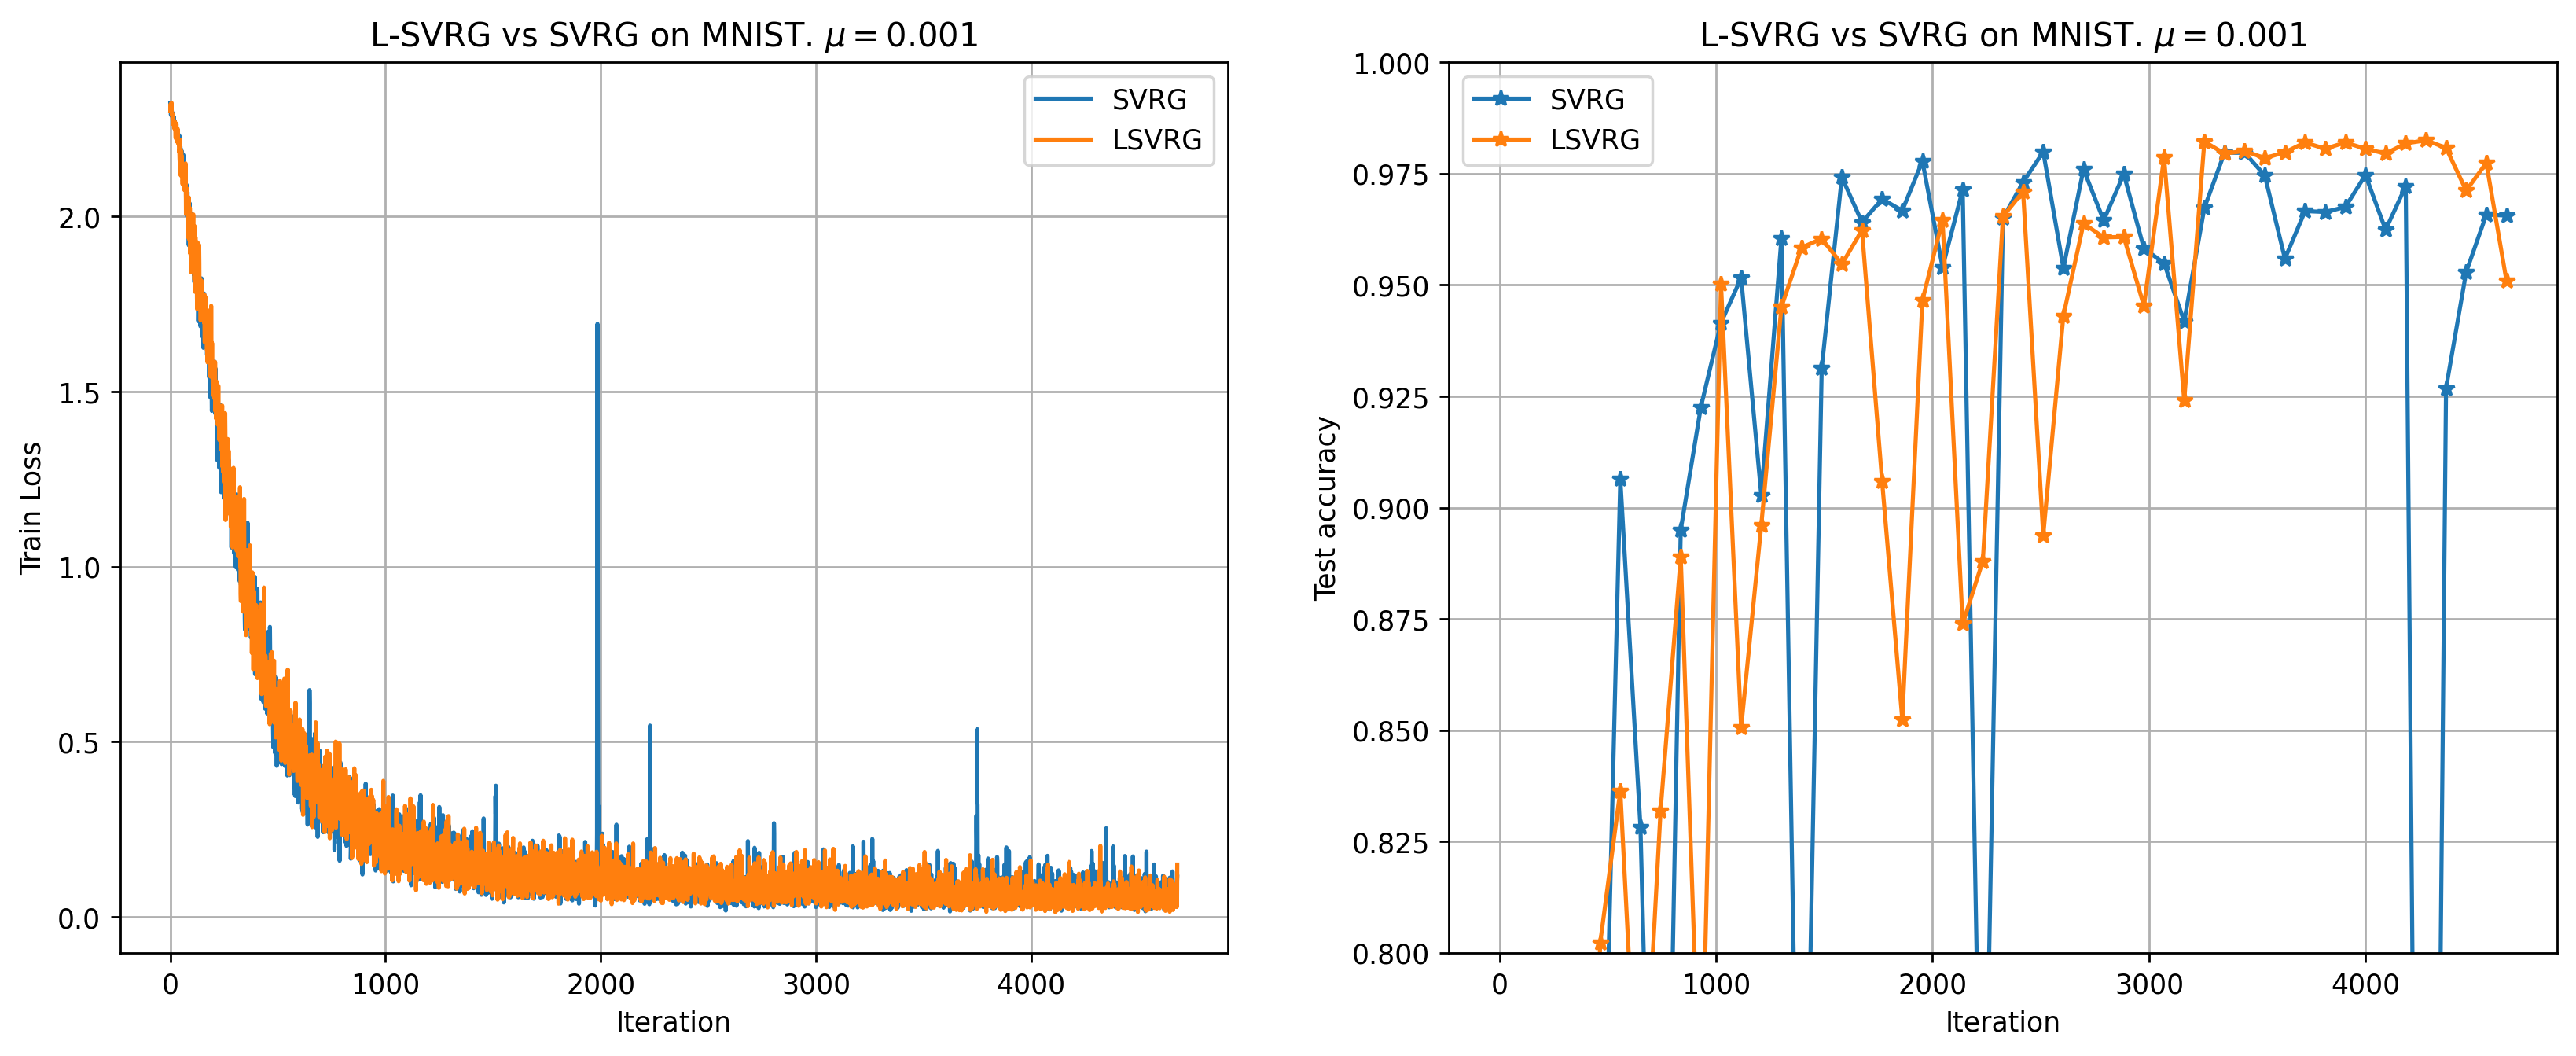

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=250)

ax[0].plot(train_loss_svrg, label='SVRG')
ax[0].plot(train_loss, label='LSVRG')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel(f'Train Loss')
ax[0].set_title('L-SVRG vs SVRG on MNIST. $\mu=0.001$')
ax[0].legend()
ax[0].grid()

ax[1].plot([x * (len(train_loader) // 5) for x in range(len(test_acc_svrg))], test_acc_svrg, marker='*', label='SVRG')
ax[1].plot([x * (len(train_loader) // 5) for x in range(len(test_acc))], test_acc, marker='*', label='LSVRG')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel(f'Test accuracy')
ax[1].set_title('L-SVRG vs SVRG on MNIST. $\mu=0.001$')
ax[1].set_ylim(0.8, 1)
ax[1].legend()
ax[1].grid()

We see that LSVRG beats SVRG on MNIST

# Implementation of L–Katyusha

In [10]:
class LKatyusha(Optimizer):
    r"""Optimization class for calculating the gradient of one iteration.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
    """
    def __init__(self, params, theta_1, theta_2, L, weight_decay=0):
        self.full_grad_pg = None
        
        lr = theta_2 / ((1 + theta_2) * theta_1)
        sigma = weight_decay / L
        
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
            
        defaults = dict(lr=lr, theta_1=theta_1, theta_2=theta_2, sigma=sigma, L=L, weight_decay=weight_decay)
        super(LKatyusha, self).__init__(params, defaults)
    
    def get_param_groups(self):
            return self.param_groups

    def set_full_grad(self, full_grad_param_groups):
        ''' 
            Set full gradient at new point w^k
        '''
        if self.full_grad_pg is None:
            self.full_grad_pg = copy.deepcopy(full_grad_param_groups)
        
        for old_group, new_group in zip(self.full_grad_pg, full_grad_param_groups):  
            for old_p, new_p in zip(old_group['params'], new_group['params']):
                old_p.grad = new_p.grad.clone()
                
    def step(self, params):
        """Performs a single optimization step.
        """
        for group, wk_group, full_grad_group in zip(self.param_groups, params, self.full_grad_pg):

            for x_k, w_k, fgp in zip(group['params'], wk_group['params'], full_grad_group['params']):
                state = self.state[x_k]
                
                if 'z' not in self.state[x_k]:
                    state['z'] = w_k
                    state['y'] = w_k
                
                    
                x_k.data = group['theta_1'] * state['z'].data + group['theta_2'] * w_k.data + \
                    + (1 - group['theta_1'] - group['theta_2']) * state['y'].data
                
                g_k = x_k.grad.data - w_k.grad.data + fgp.grad.data
                
                if group['weight_decay'] != 0:
                    g_k.add_(x_k.data, alpha=group['weight_decay'])
                
                state['prev_y'] = state['y'].data.clone()
                z_k = state['z'].data.clone()
                state['z'].data = (group['lr'] * group['sigma'] * x_k.data + state['z'].data - group['lr'] / group['L'] * g_k) / \
                    (1 + group['lr'] * group['sigma'])
                state['y'].data = x_k.data + group['theta_1'] * (state['z'].data - z_k)


class LKatyusha_Snapshot(Optimizer):
    r"""Optimization class for calculating the mean gradient (snapshot) of all samples.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
    """
    def __init__(self, params):
        defaults = dict()
        super(LKatyusha_Snapshot, self).__init__(params, defaults)
      
    def get_param_groups(self):
            return self.param_groups
    
    def set_param_groups(self, optimizer):
        """Copies the parameters from another optimizer. 
        """
        new_params = optimizer.get_param_groups()
        for group, new_group in zip(self.param_groups, new_params): 
            for p, q in zip(group['params'], new_group['params']):
                state = optimizer.state[q]
                p.data[:] = state['prev_y']

In [11]:
def train_LKatyusha(model_k, model_snapshot, optimizer_k, optimizer_snapshot, train_loader, 
                loss_fn, p, num_iter, X_test, y_test, test_freq=1, predict_fn=predict):

    def calc_full_grad():
        optimizer_snapshot.zero_grad()  
        for x, y in train_loader:
            x = x.to(device)
            y_pred = model_snapshot(x)
            y = y.to(device)
            snapshot_loss = loss_fn(y_pred, y) / len(train_loader)
            snapshot_loss.backward()
        
        optimizer_k.set_full_grad(optimizer_snapshot.get_param_groups())
    
    model_k.train()
    model_snapshot.train()
    loss = []
    test_acc = []

    # calc full grad at w_k=x_0
    calc_full_grad()
    
    k = 0
    with tqdm(total=num_iter) as pbar:
        while k < num_iter:

            for x, y in train_loader:
                x = x.to(device)
                y_pred_1 = model_k(x)
                y = y.to(device)
                loss_iter = loss_fn(y_pred_1, y)

                optimizer_k.zero_grad()
                loss_iter.backward()    

                y_pred_2 = model_snapshot(x)
                loss2 = loss_fn(y_pred_2, y)

                optimizer_snapshot.zero_grad()
                loss2.backward()

                optimizer_k.step(optimizer_snapshot.get_param_groups())
                
                if p < 1:
                    if torch.rand(1)[0] < p: # update wk
                        optimizer_snapshot.set_param_groups(optimizer_k)
                        calc_full_grad()
                else: 
                    # usual Katyusha
                    if (k % p) == 0:
                        optimizer_snapshot.set_param_groups(optimizer_k)
                        calc_full_grad()
                
                # logging 
                loss.append(loss_iter.data.item())
                
                if (k % test_freq) == 0:
                    if isinstance(X_test, torch.Tensor):
                        test_acc_iter = accuracy(predict_fn(X_test, model_k), y_test)
                        test_acc.append(test_acc_iter.data.item())
                    elif isinstance(X_test, torch.utils.data.DataLoader):
                        model_k.eval()
                        with torch.no_grad():
                            y_pred = torch.tensor([]).to(device)
                            y_true = torch.tensor([]).to(device)
                            for x_test, y_test in X_test:
                                pred = predict_fn(x_test.to(device), model_k)
                                y_pred = torch.concat([y_pred, pred])
                                y_true = torch.concat([y_true, y_test.to(device)])
                            test_acc_iter = accuracy(y_pred, y_true)
                            test_acc.append(test_acc_iter.data.item())
                        model_k.train()

                k += 1
                pbar.update(1)

    return loss, test_acc

### Mushrooms

In [21]:
mushrooms_model = nn.Linear(X.shape[1], 1, bias=False)
mushrooms_model.weight.data = torch.randn(1, X.shape[1])

model = mushrooms_model.to(device)
model_wk = copy.deepcopy(mushrooms_model).to(device)

In [12]:
def loss_mushrooms(y_pred, y):
    assert y_pred.shape[1] == 1 and len(y_pred.shape) == 2
    y_pred = y_pred.ravel()
    assert len(y_pred.shape) == len(y.shape) == 1
    
    return torch.mean(torch.log(1 + torch.exp(-y * y_pred)))

In [13]:
BATCH_SIZE = 128

train_ds = torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)

X_test_tensor = torch.tensor(X_test).float().to(device)
y_test_tensor = torch.tensor(y_test).float().to(device)

In [188]:
n = len(train_loader)
MU = 10e-3
L = estimate_L(X_train, MU)
sigma = MU / L
THETA_1 = min(np.sqrt(2*sigma*n/3), 0.5)
THETA_2 = 0.5

optimizer = LKatyusha(model.parameters(), THETA_1, THETA_2, L, MU)
optimizer_snapshot = LKatyusha_Snapshot(model_wk.parameters())

In [346]:
P = 1 / len(train_loader)
num_iter = 20 * len(train_loader) # 20 epochs

train_loss, test_acc = \
    train_LKatyusha(model, model_wk, optimizer, optimizer_snapshot, train_loader, loss_mushrooms, 
                P, num_iter, X_test_tensor, y_test_tensor)

  0%|          | 0/1000 [00:00<?, ?it/s]

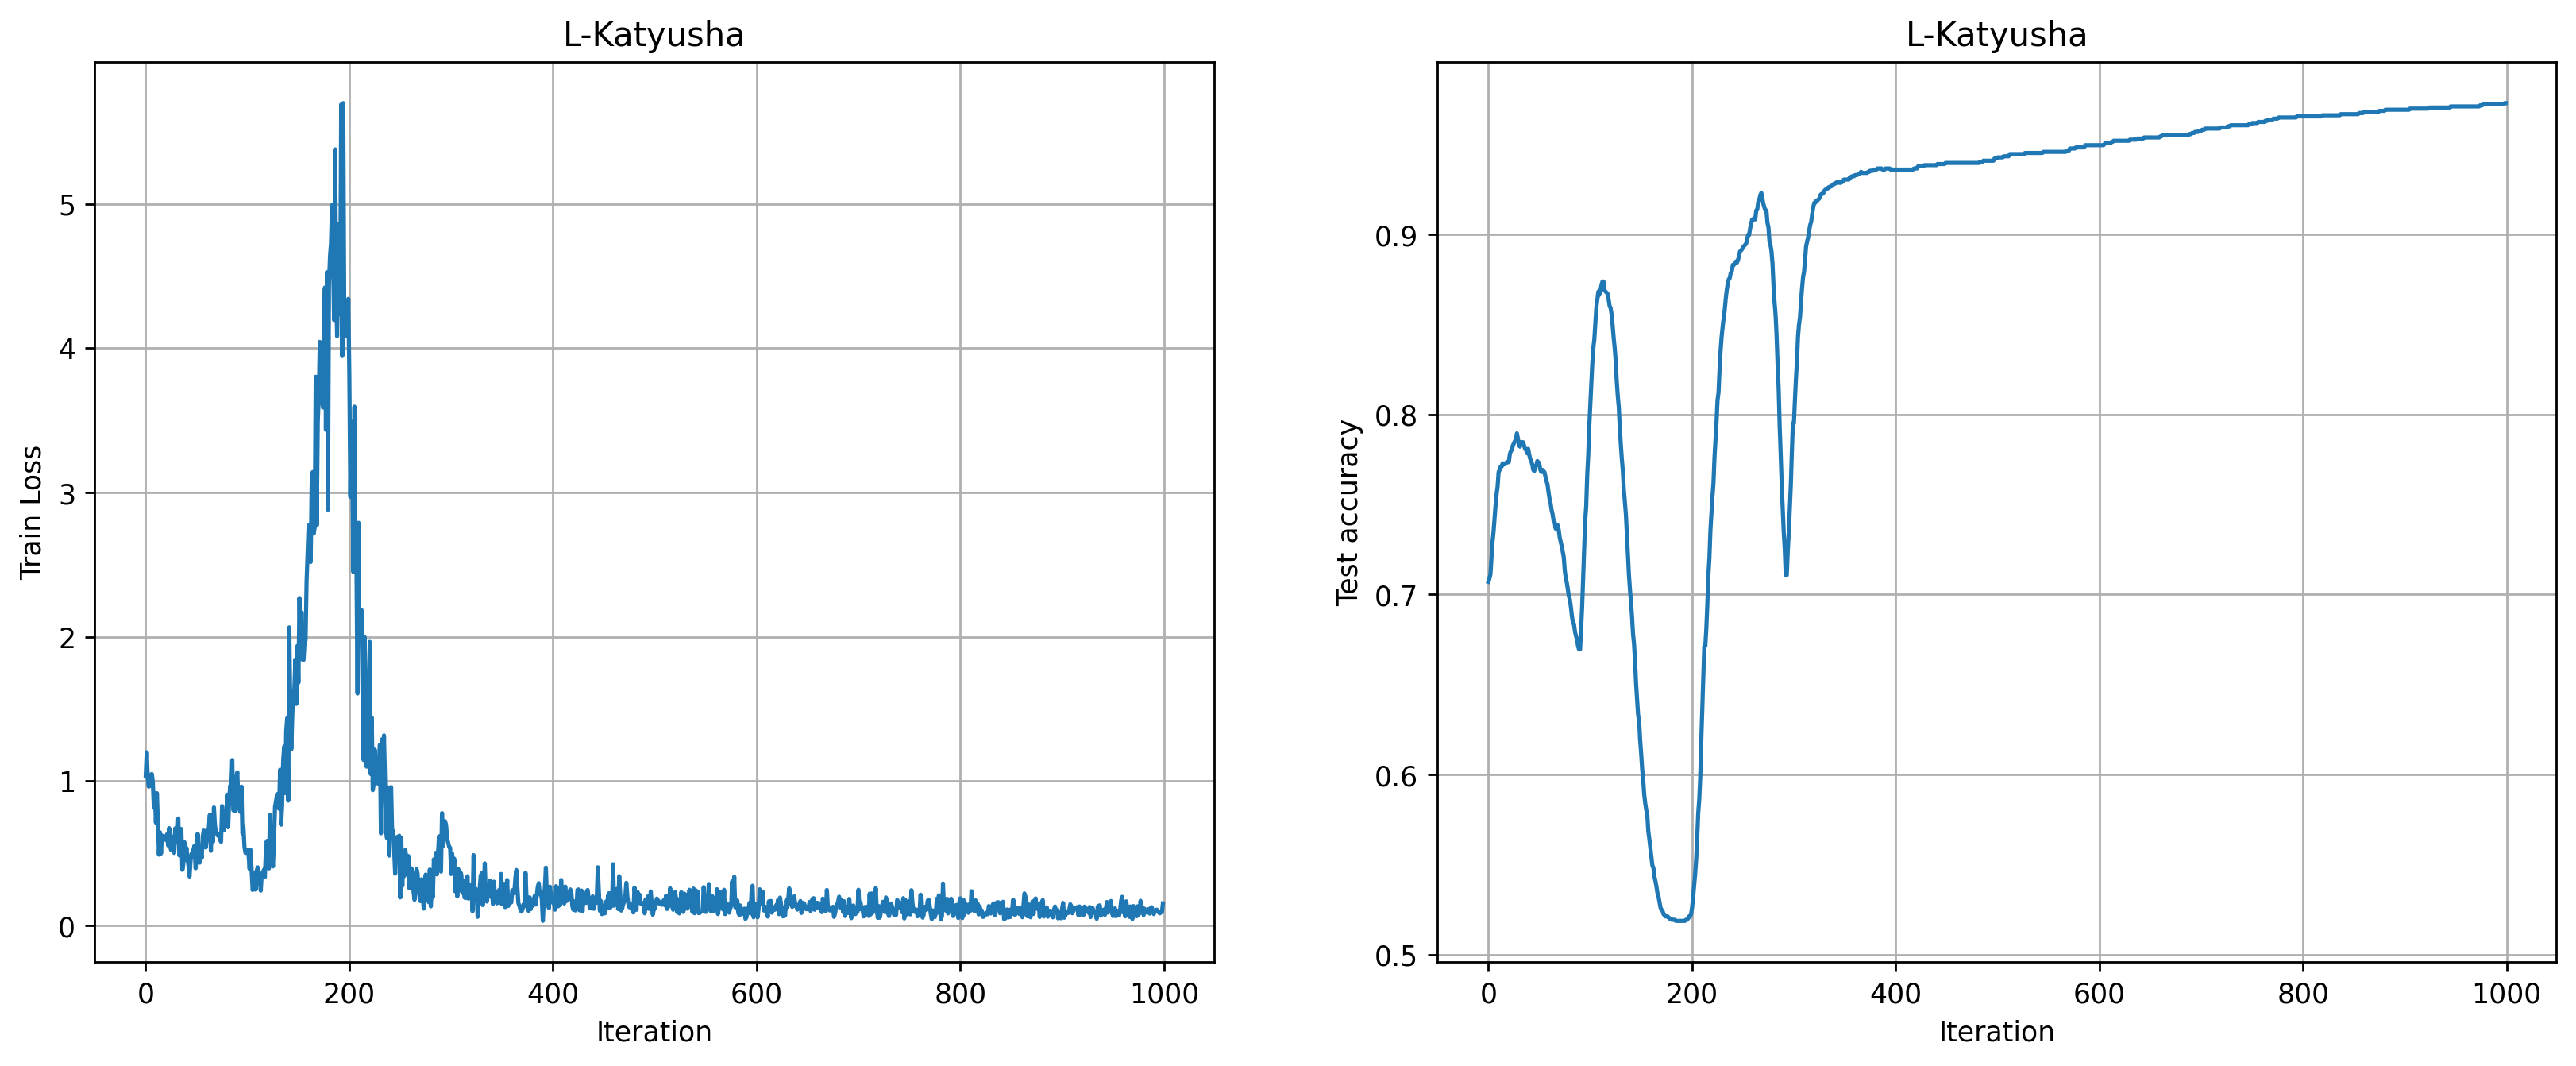

In [347]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=250)

ax[0].plot(train_loss)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel(f'Train Loss')
ax[0].set_title('L-Katyusha')
ax[0].grid()

ax[1].plot(test_acc)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel(f'Test accuracy')
ax[1].set_title('L-Katyusha')
ax[1].grid()

### Choosing probability

In [19]:
n = len(train_loader)
MU = 10e-9
L = estimate_L(X_train, MU)
sigma = MU / L
THETA_1 = min(np.sqrt(2*sigma*n/3), 0.5)
THETA_2 = 0.5

p_grid = np.linspace(0, 1/len(train_loader), num=5)
p_grid = np.hstack([p_grid, len(train_loader)])
# p_grid = [len(train_loader)]

loss_per_step = []
accuracy_per_step = []

del model, model_wk, optimizer, optimizer_snapshot
num_iter = 20*len(train_loader)

for p in tqdm(p_grid):
    mushrooms_model = nn.Linear(X.shape[1], 1, bias=False)
    mushrooms_model.weight.data = torch.randn(1, X.shape[1])

    model = mushrooms_model.to(device)
    model_wk = copy.deepcopy(mushrooms_model).to(device)
    
    optimizer = LKatyusha(model.parameters(), THETA_1, THETA_2, L, MU)
    optimizer_snapshot = LKatyusha_Snapshot(model_wk.parameters())
    
    train_loss, test_acc = \
    train_LKatyusha(model, model_wk, optimizer, optimizer_snapshot, train_loader, loss_mushrooms, 
                p, num_iter, X_test_tensor, y_test_tensor)
    
    loss_per_step.append(train_loss)
    accuracy_per_step.append(test_acc)
    
    model.to('cpu')
    model_wk.to('cpu')      

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

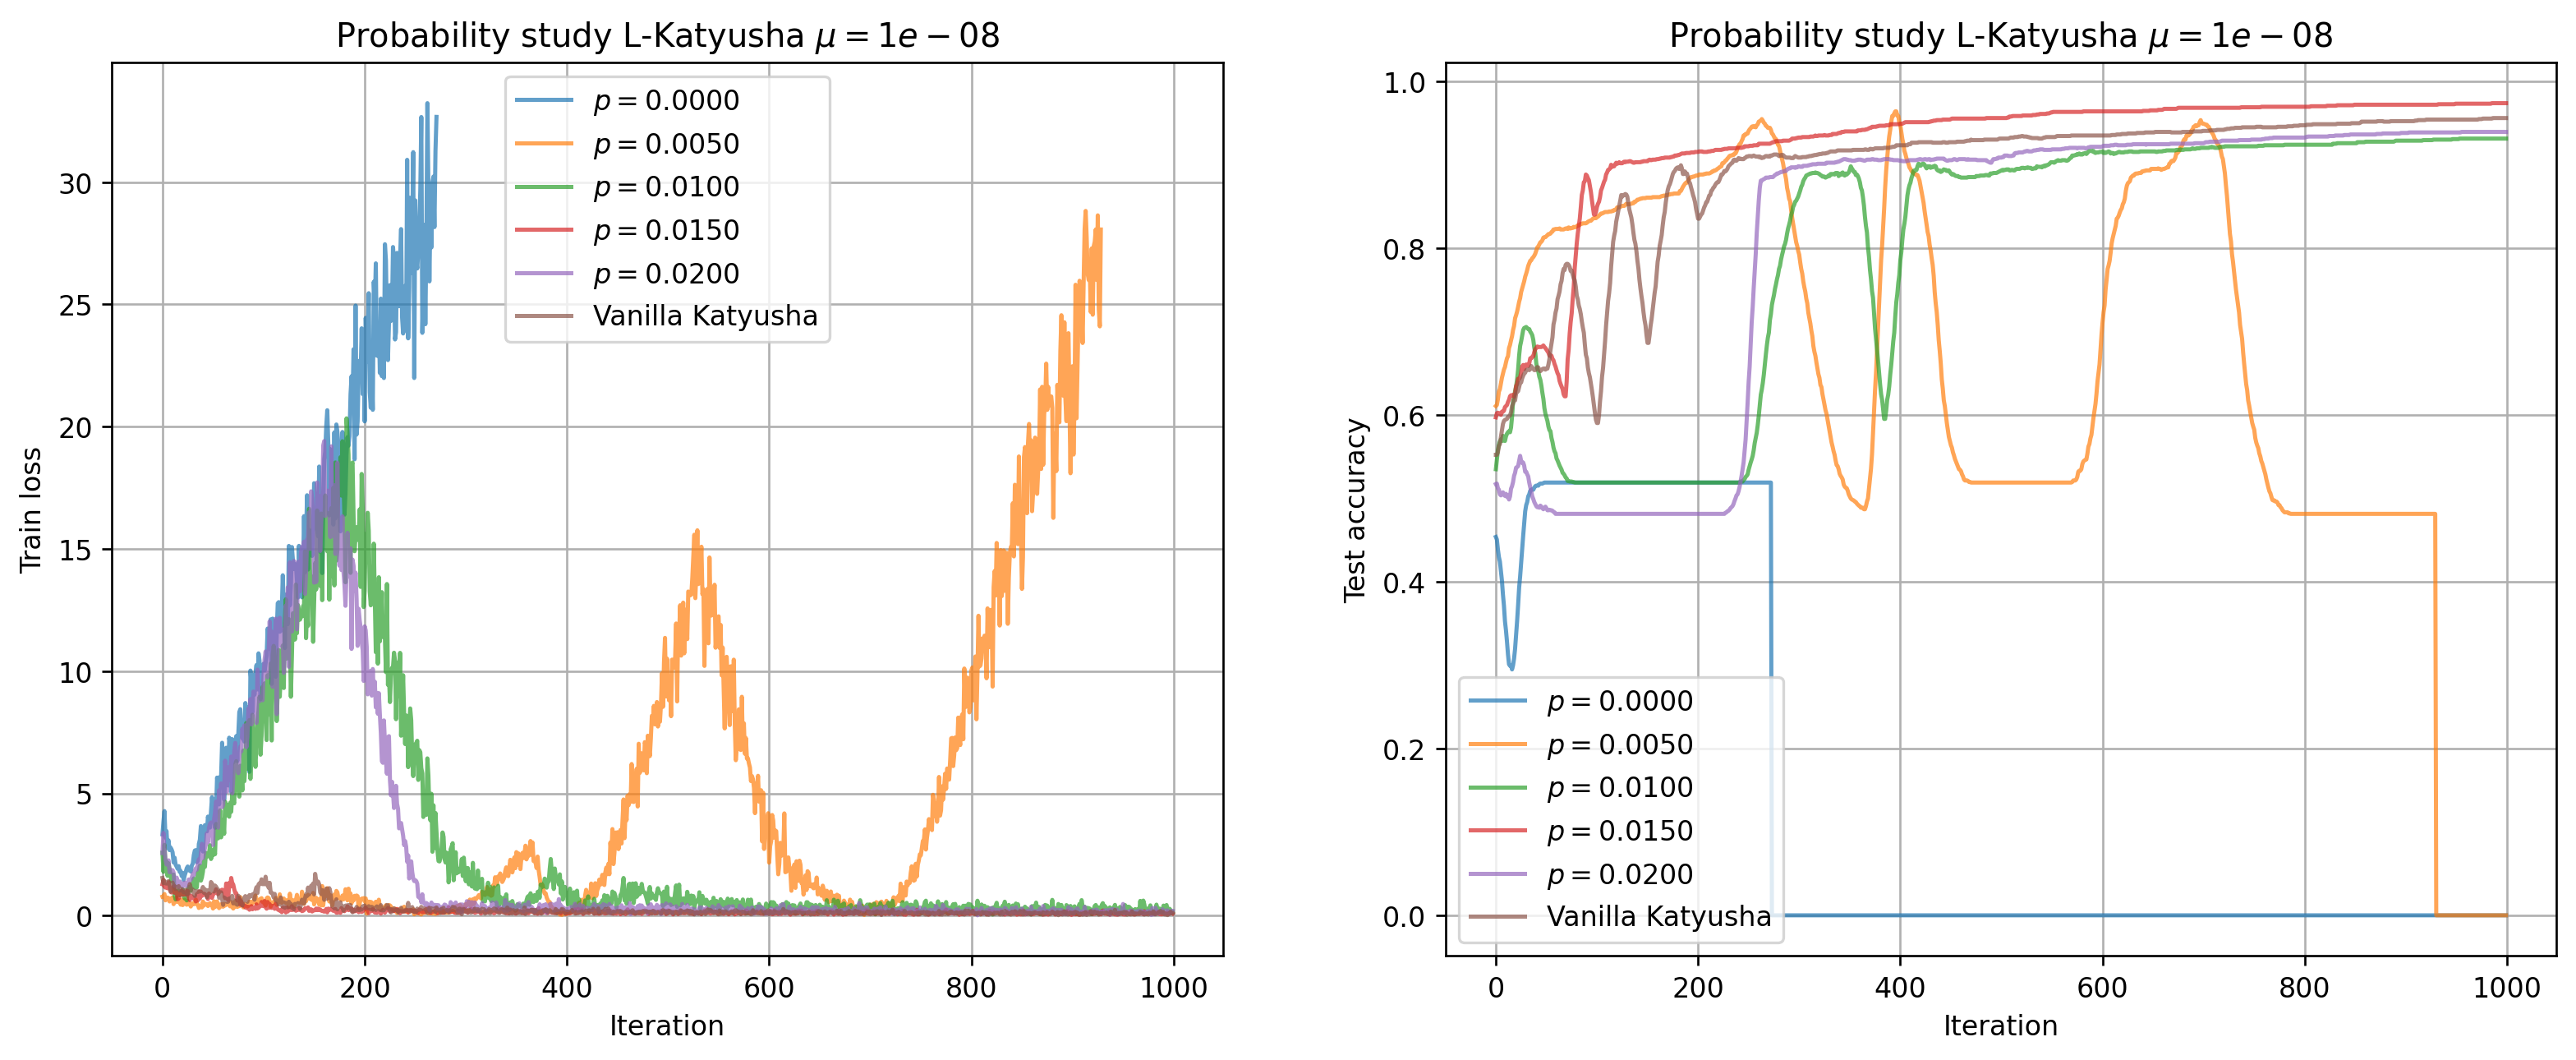

In [20]:
labels = ['$p=$' + f'{p:.4f}' for p in p_grid] 
labels[-1] = 'Vanilla Katyusha'
# labels[3] = '$p=\\frac{1}{N}=$' + f'{step_grid[3]:.4f}'

fig, axs = plt.subplots(1, 2, figsize=(16,6), dpi=240)

ax = axs[0]
for i, losses in enumerate(loss_per_step):
    ax.plot(losses, label=labels[i], alpha=0.7)
# plt.yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(f'Train loss')
# plt.ylim(0.8, 1)
ax.set_title(f'Probability study L-Katyusha $\mu={MU}$')
ax.legend()
ax.grid()


ax = axs[1]
for i, test_acc in enumerate(accuracy_per_step):
    ax.plot(test_acc, label=labels[i], alpha=0.7)
# plt.yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(f'Test accuracy')
# plt.ylim(0.8, 1)
ax.set_title(f'Probability study L-Katyusha $\mu={MU}$')
ax.legend()
ax.grid()

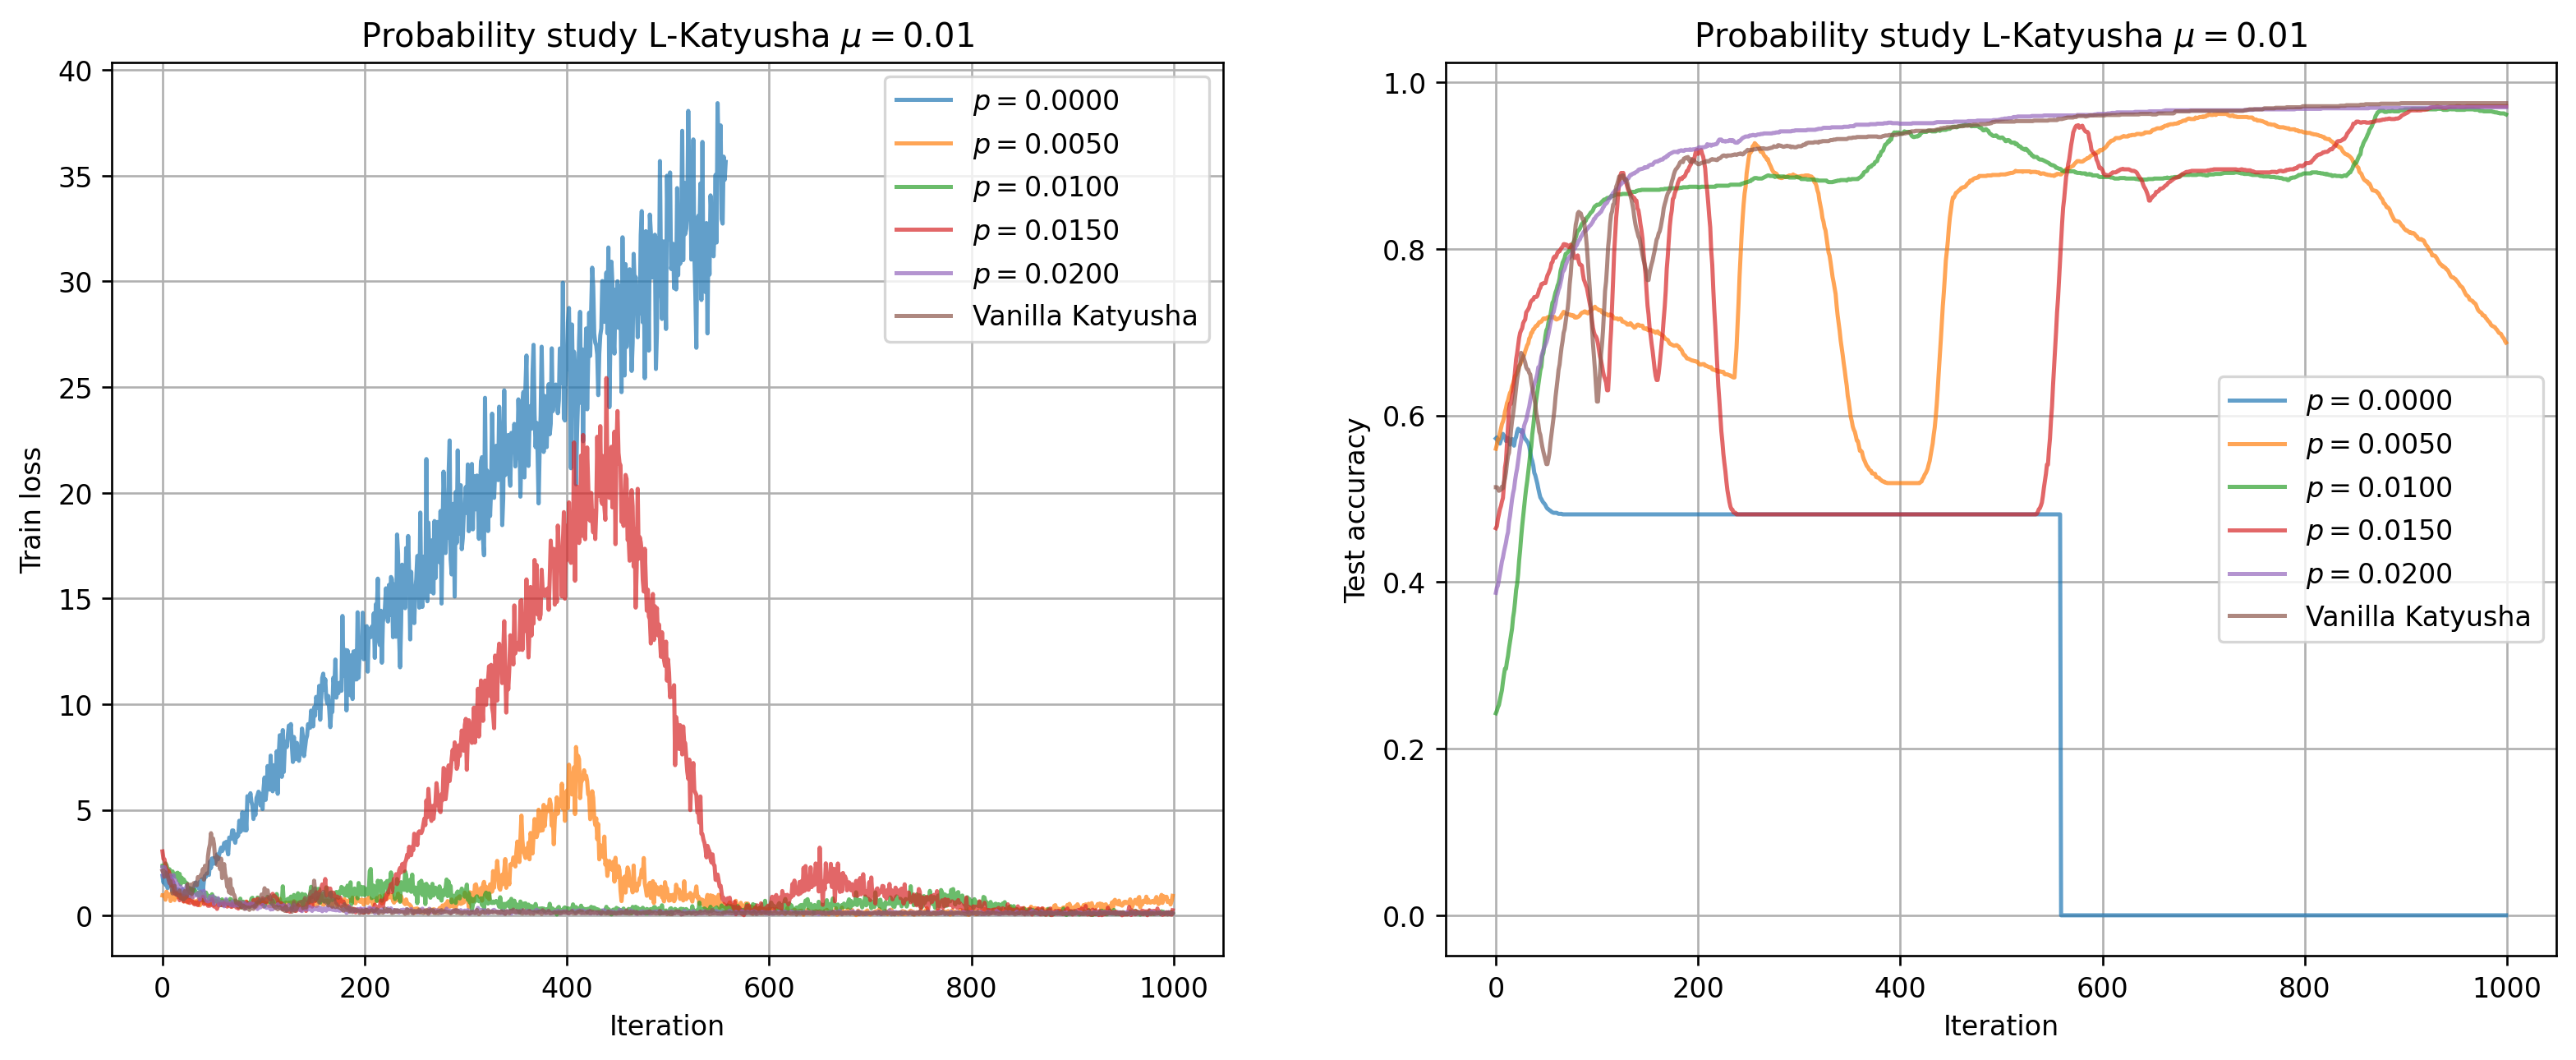

In [18]:
labels = ['$p=$' + f'{p:.4f}' for p in p_grid] 
labels[-1] = 'Vanilla Katyusha'
# labels[3] = '$p=\\frac{1}{N}=$' + f'{step_grid[3]:.4f}'

fig, axs = plt.subplots(1, 2, figsize=(16,6), dpi=240)

ax = axs[0]
for i, losses in enumerate(loss_per_step):
    ax.plot(losses, label=labels[i], alpha=0.7)
# plt.yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(f'Train loss')
# plt.ylim(0.8, 1)
ax.set_title(f'Probability study L-Katyusha $\mu={MU}$')
ax.legend()
ax.grid()


ax = axs[1]
for i, test_acc in enumerate(accuracy_per_step):
    ax.plot(test_acc, label=labels[i], alpha=0.7)
# plt.yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(f'Test accuracy')
# plt.ylim(0.8, 1)
ax.set_title(f'Probability study L-Katyusha $\mu={MU}$')
ax.legend()
ax.grid()

### MNIST

In [143]:
mnist_model = nn.Sequential(
    nn.Conv2d(1, 16, 3),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

model = mnist_model.to(device)
model_wk = copy.deepcopy(mnist_model).to(device)

In [144]:
BATCH_SIZE = 128
img_dir = '/ssd_new/r.fazylov/'

TRANSFORMS = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = torchvision.datasets.MNIST(img_dir, download=True, train=True, transform=TRANSFORMS)
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True, pin_memory=True)

test_ds = torchvision.datasets.MNIST(img_dir, download=True, train=False, transform=TRANSFORMS)
test_loader = torch.utils.data.DataLoader(test_ds, 4096, shuffle=False, num_workers=4, drop_last=False, pin_memory=True)

In [145]:
THETA_1, THETA_2, THETA_2/((1+THETA_2)*THETA_1)

(0.07708919475344343, 0.5, 4.323995527511253)

In [146]:
n = len(train_loader)
MU = 10e-5
L = estimate_L(X_train, MU)
sigma = MU / L
THETA_1 = min(np.sqrt(2*sigma*n/3), 0.5)
THETA_2 = 0.5

optimizer = LKatyusha(model.parameters(), THETA_1, THETA_2, L, MU)
optimizer_snapshot = LKatyusha_Snapshot(model_wk.parameters())

mnist_loss = torch.nn.CrossEntropyLoss()

In [147]:
summary(mnist_model, (128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 26, 26]         160
├─BatchNorm2d: 1-2                       [128, 16, 26, 26]         32
├─ReLU: 1-3                              [128, 16, 26, 26]         --
├─Conv2d: 1-4                            [128, 32, 24, 24]         4,640
├─BatchNorm2d: 1-5                       [128, 32, 24, 24]         64
├─ReLU: 1-6                              [128, 32, 24, 24]         --
├─Conv2d: 1-7                            [128, 64, 22, 22]         18,496
├─BatchNorm2d: 1-8                       [128, 64, 22, 22]         128
├─ReLU: 1-9                              [128, 64, 22, 22]         --
├─Conv2d: 1-10                           [128, 128, 20, 20]        73,856
├─BatchNorm2d: 1-11                      [128, 128, 20, 20]        256
├─ReLU: 1-12                             [128, 128, 20, 20]        --
├

In [148]:
P = 1 / len(train_loader)
num_iter = 1 * len(train_loader)

train_loss, test_acc = \
    train_LKatyusha(model, model_wk, optimizer, optimizer_snapshot, train_loader, mnist_loss, 
                P, num_iter, test_loader, None, test_freq=len(train_loader) // 5, predict_fn=predict_multiclass)

  0%|          | 0/468 [00:00<?, ?it/s]

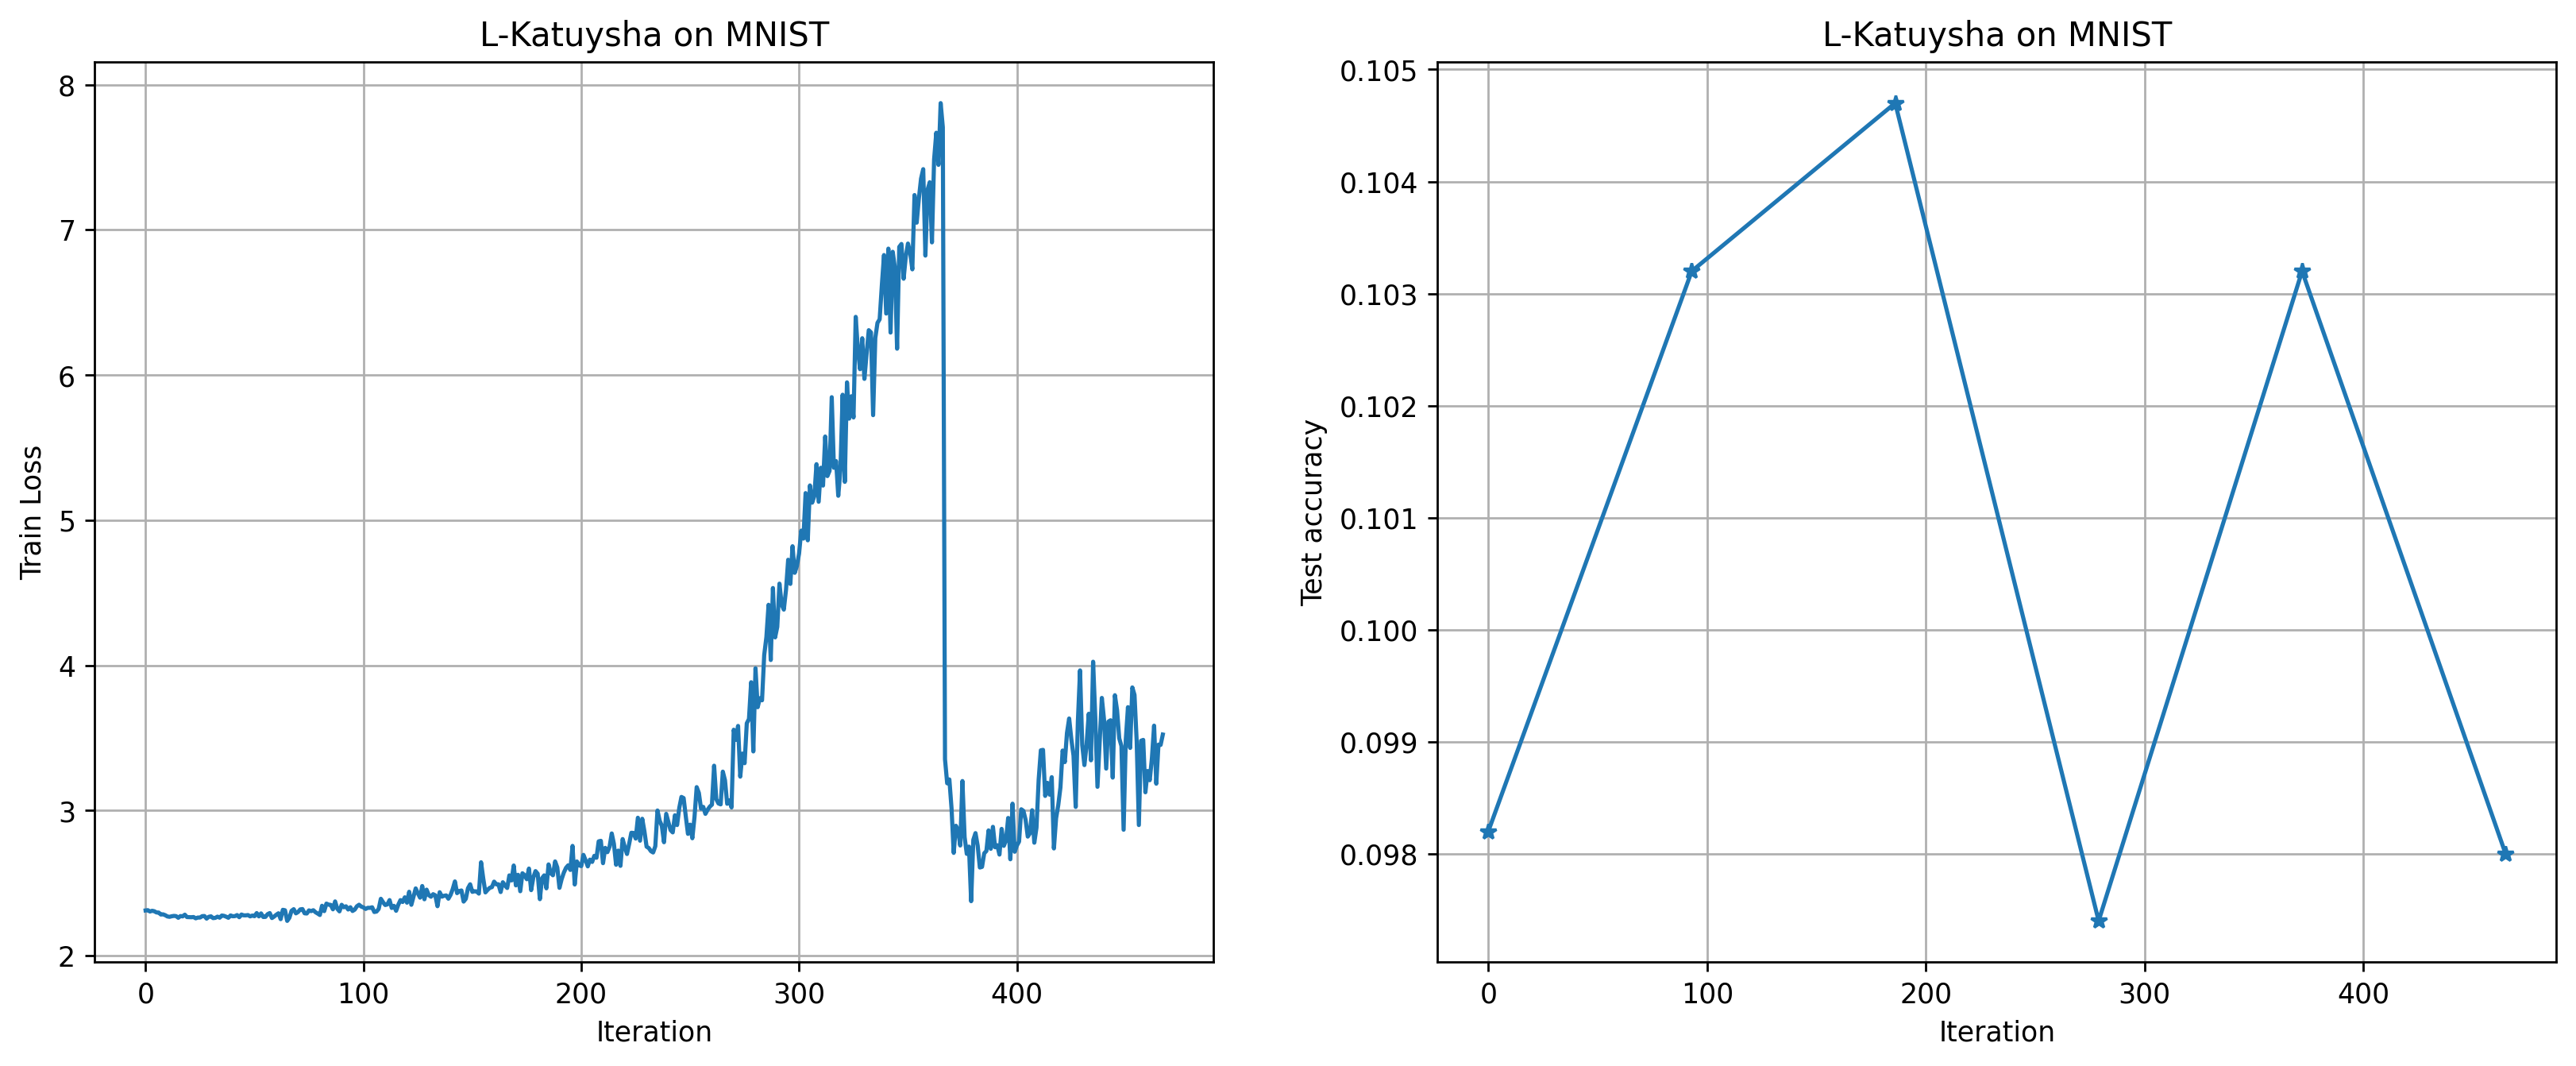

In [149]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=250)

ax[0].plot(train_loss)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel(f'Train Loss')
ax[0].set_title('L-Katuysha on MNIST')
ax[0].grid()

ax[1].plot([x * (len(train_loader) // 5) for x in range(len(test_acc))], test_acc, marker='*')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel(f'Test accuracy')
ax[1].set_title('L-Katuysha on MNIST')
ax[1].grid()